In [2]:
# %matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

In [3]:
import seaborn as sns

def setstyle(stylename):
    sns.set()
    sns.set_style(stylename, {"font.family": "serif"})
    sns.set_context("paper",font_scale=0.9)
    
    pgf_with_latex = {                      # setup matplotlib to use latex for output
        "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
        "text.usetex": True,                # use LaTeX to write all text
        "font.family": "serif",
        "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
        "font.sans-serif": [],
        "font.monospace": [],
        "axes.labelsize": 10,               # LaTeX default is 10pt font.
        "font.size": 10,
        "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    #     "figure.figsize": fig_size,     # default fig size of 0.9 textwidth
        "pgf.preamble": [
            r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
            r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
            ]
        }
    mpl.rcParams.update(pgf_with_latex)


def savefig(fig,fn,width_inches,height_inches):
    fig.set_size_inches(width_inches, height_inches)
    try:
        plt.tight_layout()
    except:
        pass
    fig.savefig("{}.png".format(fn),dpi=600)
    fig.savefig("{}.pdf".format(fn))
    fig.savefig("{}.svg".format(fn))
    return fig

IEEE_2COL = 7.16 # IEEE \textwidth in inches
IEEE_1COL = 3.5 # IEEE \columnwidth in inches

def makecross(x,y):
    l=0.5
    ax.plot([x-l,x+l],[y,y],color="k",linewidth=1)
    ax.plot([x,x],[y-l,y+l],color="k",linewidth=1)

In [5]:
with open('waypoints_dataset.pkl', 'rb') as f:
    d = pickle.load(f,encoding='latin1')
color = dict(JOYSTICK=(0.3,0.5,0.7), POINTING=(0.1,0.4,0.1))
d.keys()

dict_keys(['moves', 'data', 'targets'])

In [39]:
data = d["data"]
moves = d["moves"]
targets = d["targets"]

moves = moves.loc[moves.session_id != 5]

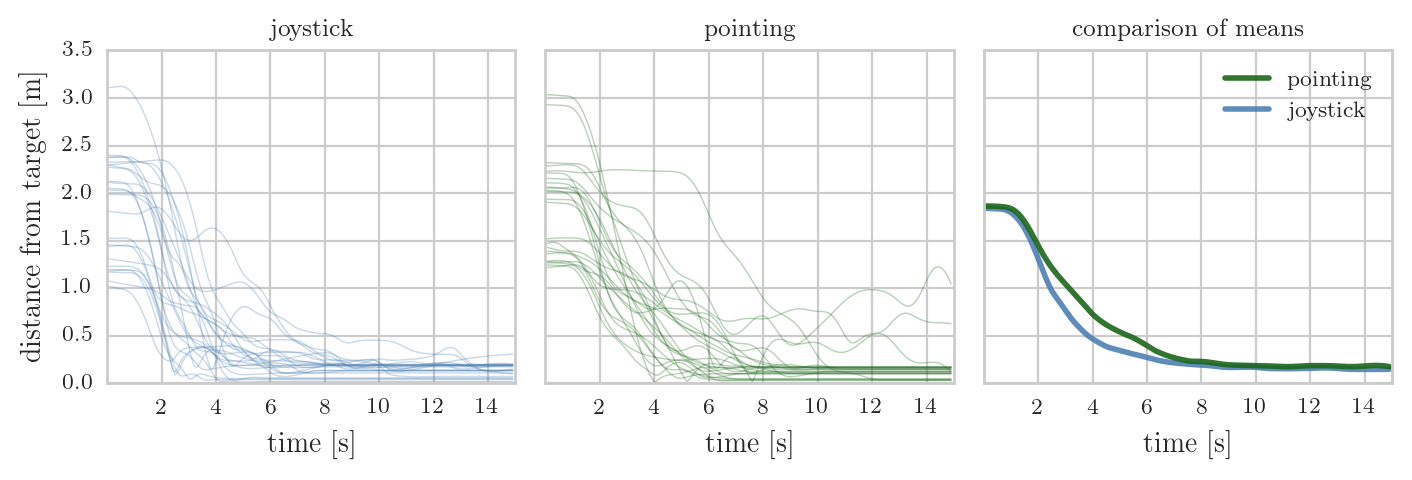

In [42]:
#%% Analyze distance to target

def dist_to_target(xy,t0,target_x,target_y,resample_t):
    dist=np.linalg.norm(xy.values-np.array([[target_x,target_y]]),axis=1)
    dist_t=(xy.index-t0)/pd.Timedelta("1s")
    return np.interp(resample_t, dist_t, dist)

t0,t1=0,15
t=np.arange(t0,t1,0.1)

setstyle("whitegrid")
fig,axs=plt.subplots(ncols=3,sharex=True,sharey=True)
handles=dict()
for ax,interface in zip(axs,["JOYSTICK","POINTING"]):
    c=color[interface]
    dists=[]
    for _,m in moves[moves["interface"]==interface].iterrows():
        target = targets.loc[m.target]
        p = data.loc[m.t0:m.t1]
        p = p.set_index(p.index.tz_localize(None))
        dist=dist_to_target(
            p.loc[:,["gt_x","gt_y"]],
            m.t0,  
            target.x, target.y, t)
        if(dist[-1]) > np.inf:  # Set to 0.5 to filter out the wanderers in POINTING  (who?)
            print("DISCARDING")
            continue
        ax.plot(t,dist,color=c,alpha=0.3,linewidth=0.5)
        # ax.axvline(x=(m.t1-m.t0)/pd.Timedelta("1s"),color=c,alpha=0.3,linewidth=0.5)
        dists.append(dist)
    handles[interface] = axs[2].plot(
        t,np.mean(np.array(dists),axis=0),color=c,alpha=0.9,linewidth=2,linestyle="-")
    ax.set(title=interface.lower(),
           xlim=[t0,t1])
           
for ax in axs:
    ax.set(xlabel="time [s]")
    from matplotlib.ticker import MaxNLocator
    #ax.xaxis.set_major_locator(MaxNLocator(prune='both'))
    ax.set_xticks(np.arange(2,15,2))
    
axs[0].set(ylabel="distance from target [m]")
axs[2].set(title="comparison of means")
axs[2].legend([h[0] for l,h in handles.items()],
              [l.lower() for l,h in handles.items()],
              loc="upper right")

savefig(fig, "disttotarget-waypoints", IEEE_2COL, 2.5)
